# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
from cs231n.classifiers import Softmax

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [4]:
from cs231n.classifiers.softmax import softmax_loss_naive
from cs231n.classifiers.softmax import softmax_loss_vectorized

In [5]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

Test
loss: 2.331708
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [30]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 20)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 20)

Test


KeyboardInterrupt: 

In [33]:
# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_vectorized(W, X_dev, y_dev, 0)
f = lambda w: softmax_loss_vectorized(w, X_dev, y_dev, 0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.122730 analytic: -0.122730, relative error: 1.618643e-07
numerical: -0.011118 analytic: -0.011118, relative error: 3.140105e-06
numerical: 0.804930 analytic: 0.804930, relative error: 1.669996e-09
numerical: -1.467934 analytic: -1.467934, relative error: 7.923331e-09
numerical: 0.751231 analytic: 0.751231, relative error: 3.919346e-08
numerical: 0.000635 analytic: 0.000635, relative error: 6.714847e-05
numerical: 0.221358 analytic: 0.221358, relative error: 2.070731e-07
numerical: 1.395881 analytic: 1.395881, relative error: 9.924403e-09
numerical: 0.292291 analytic: 0.292291, relative error: 2.581070e-08
numerical: -1.287130 analytic: -1.287130, relative error: 3.117381e-08


In [5]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
tic = time.time()
loss, grad = softmax_loss_vectorized(W, X_dev, y_dev, 0.0)
print(time.time()-tic)

0.0030088424682617188


In [6]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

Test
naive loss: 2.418199e+00 computed in 10.499703s
vectorized loss: 2.418199e+00 computed in 0.003008s
Loss difference: 0.000000
Gradient difference: 0.000000


### Smoke test

In [11]:
svm = Softmax()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4, num_iters=50000, verbose=True)
toc = time.time()
#print('That took %fs' % (toc - tic))

# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.semilogx(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

iteration 0 / 50000: loss 775.326716


KeyboardInterrupt: 

In [12]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
-
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

Learning rate is 1.00e-07, regularization is 1.00e+04
Train accuracy is 0.3289, validation accuracy is 0.3390


Learning rate is 1.00e-07, regularization is 3.25e+04
Train accuracy is 0.3390, validation accuracy is 0.3420


Learning rate is 1.00e-07, regularization is 5.50e+04
Train accuracy is 0.3491, validation accuracy is 0.3420


Learning rate is 1.00e-07, regularization is 7.75e+04
Train accuracy is 0.3578, validation accuracy is 0.3620


Learning rate is 1.00e-07, regularization is 1.00e+05
Train accuracy is 0.3679, validation accuracy is 0.3620


Learning rate is 1.78e-07, regularization is 1.00e+04
Train accuracy is 0.3639, validation accuracy is 0.3470


Learning rate is 1.78e-07, regularization is 3.25e+04
Train accuracy is 0.3737, validation accuracy is 0.3570


Learning rate is 1.78e-07, regularization is 5.50e+04
Train accuracy is 0.3859, validation accuracy is 0.3900


Learning rate is 1.78e-07, regularization is 7.75e+04
Train accuracy is 0.3904, validation accuracy is 0

In [13]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = stm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.405000


iteration 0 / 50000: loss 1096.947606, learning rate 8.000e-07
iteration 1000 / 50000: loss 600.922340, learning rate 7.686e-07
iteration 2000 / 50000: loss 348.244233, learning rate 7.385e-07
iteration 3000 / 50000: loss 209.364281, learning rate 7.095e-07
iteration 4000 / 50000: loss 130.550305, learning rate 6.817e-07
iteration 5000 / 50000: loss 84.516970, learning rate 6.550e-07
iteration 6000 / 50000: loss 57.356360, learning rate 6.293e-07
iteration 7000 / 50000: loss 40.608393, learning rate 6.046e-07
iteration 8000 / 50000: loss 30.493674, learning rate 5.809e-07
iteration 9000 / 50000: loss 23.898296, learning rate 5.581e-07
iteration 10000 / 50000: loss 19.715571, learning rate 5.362e-07
iteration 11000 / 50000: loss 16.966974, learning rate 5.152e-07
iteration 12000 / 50000: loss 15.054569, learning rate 4.950e-07
iteration 13000 / 50000: loss 13.937531, learning rate 4.756e-07
iteration 14000 / 50000: loss 13.140791, learning rate 4.569e-07
iteration 15000 / 50000: loss 12

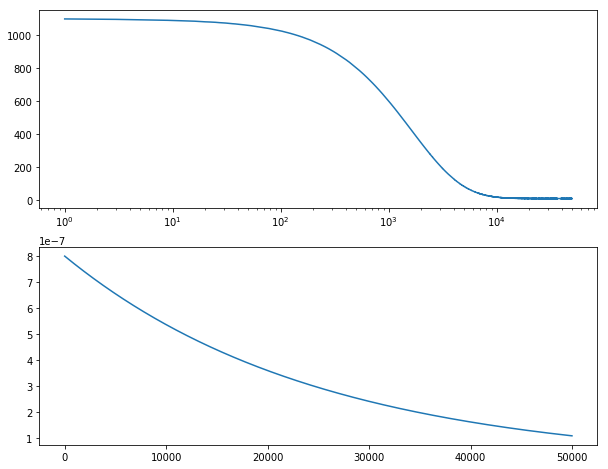

In [15]:
# Learning rate is 2.78e-06, regularization is 7.00e+04
# Train accuracy is 0.4419, validation accuracy is 0.4020

stm = Softmax()
err, rate = stm.train(X_train, y_train, learning_rate=8e-7, reg=7e4,
                num_iters=50000, verbose=True, decay=4e-5)

plt.subplot(211)
plt.semilogx(err)

plt.subplot(212)
plt.plot(rate)

In [7]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = stm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.405000


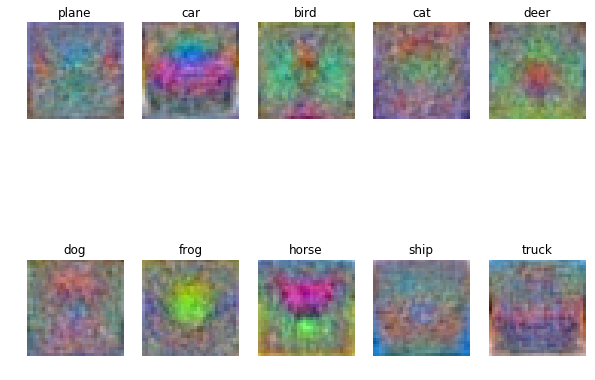

In [14]:
# Visualize the learned weights for each class
w = stm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])